## Data Collection and Preprocessing

In [3]:
pip install xgboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 11.5 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [180]:
import math
import pandas as pd
import os
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split


In [59]:
pd.set_option('display.max_columns', None)

In [195]:
# Initialize dictionaries of dataframes

data = {}
years = [18, 19, 20, 21, 22, 23]


In [196]:
# Obtain data

for x in years:
    data[x] = pd.read_csv('cleanData/refined/pbp_refined_20' + str(x) + '.csv')

print("Done")

Done


/var/folders/z2/rm0rvjws51g2b4p7_0ns_31w0000gp/T/ipykernel_55469/3123396247.py:4: DtypeWarning: Columns (30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  data[x] = pd.read_csv('cleanData/refined/pbp_refined_20' + str(x) + '.csv')


In [197]:
df = pd.concat(data, ignore_index=True)

In [199]:
#df.columns

#print(df.info())

In [200]:
# Filter data based on 2 min drill

df = df[df['offense_personnel'] == '1 RB, 1 TE, 3 WR']
df = df[df['qtr'] == 4]
df = df[df['quarter_seconds_remaining'] <= 120]

df.dropna(subset=['epa'], inplace=True) # For some reason there is a NaN for EPA in 18385

print(df.shape)

(5030, 62)


In [201]:
# Encode data

# Encode categorical features (route_type and coverage_type)
le_route = LabelEncoder()
df['route_encoded'] = le_route.fit_transform(df['route'])

le_coverage = LabelEncoder()
df['coverage_encoded'] = le_coverage.fit_transform(df['defense_coverage_type'])

le_pressure = LabelEncoder()
df['pressure_encoded'] = le_pressure.fit_transform(df['was_pressure'])

le_length = LabelEncoder()
df['length_encoded'] = le_length.fit_transform(df['pass_length'])

le_location = LabelEncoder()
df['location_encoded'] = le_location.fit_transform(df['pass_location'])


print(df.shape)

(5030, 67)


## Model Implementation

In [264]:
#X = df[['yardline_100', 'quarter_seconds_remaining', 'ydstogo', 'play_type', 'yards_gained', 'no_huddle', 'qb_scramble', 'pass_length', 
#        'pass_location', 'air_yards', 'yards_after_catch', 'run_location', 'run_gap', 'score_differential', 'epa', 'out_of_bounds',
#        'offense_formation', 'offense_personnel', 'defenders_in_box', 'defense_personnel', 'number_of_pass_rushers', 'ngs_air_yards',
#        'time_to_throw', 'was_pressure', 'route']]

X = df[['yardline_100', 'quarter_seconds_remaining', 'ydstogo', 'no_huddle', 'length_encoded', 'location_encoded', 'out_of_bounds',
        'defenders_in_box', 'number_of_pass_rushers', 'time_to_throw', 'pressure_encoded', 'route_encoded', 'coverage_encoded']]

y = df[['epa']]


In [265]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test, = train_test_split(
    X, y, test_size=0.2, random_state=97
)

In [266]:
# Train XGBoost regression model to predict EPA
model_epa = xgb.XGBRegressor(objective="reg:squarederror")
model_epa.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Model Evaluation

In [267]:
# Make predictions based on testing data

y_pred = model_epa.predict(X_test)


In [268]:
# Calculate MAE (Mean Absolute Error)
mae = mean_absolute_error(y_test, y_pred)

# Calculate MSE (Mean Squared Error)
mse = mean_squared_error(y_test, y_pred)

# Calculate RMSE (Root Mean Squared Error)
rmse = math.sqrt(mse)

# Calculate R-squared
r2 = r2_score(y_test, y_pred)

# Display the evaluation metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

Mean Absolute Error (MAE): 0.9670010678383432
Mean Squared Error (MSE): 2.2035998879009107
Root Mean Squared Error (RMSE): 1.4844527233633649
R-squared (R²): -0.18691380354527354


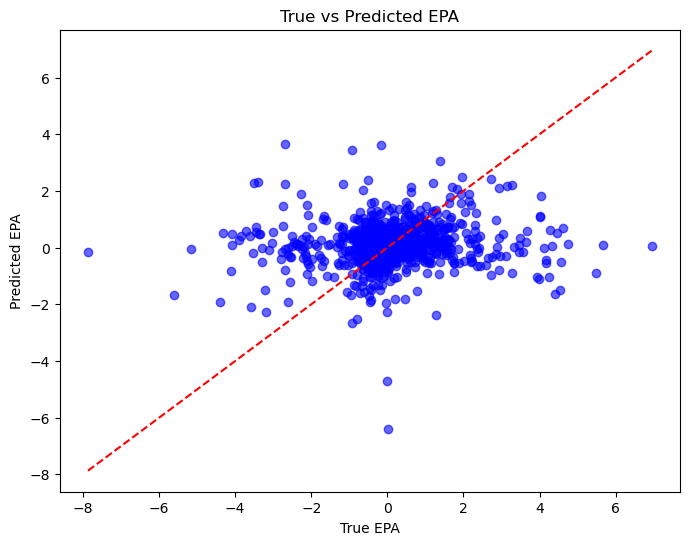

In [269]:
# Visualize Model
# Plot true vs predicted EPA values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')  # Line of perfect prediction
plt.title('True vs Predicted EPA')
plt.xlabel('True EPA')
plt.ylabel('Predicted EPA')
plt.show()

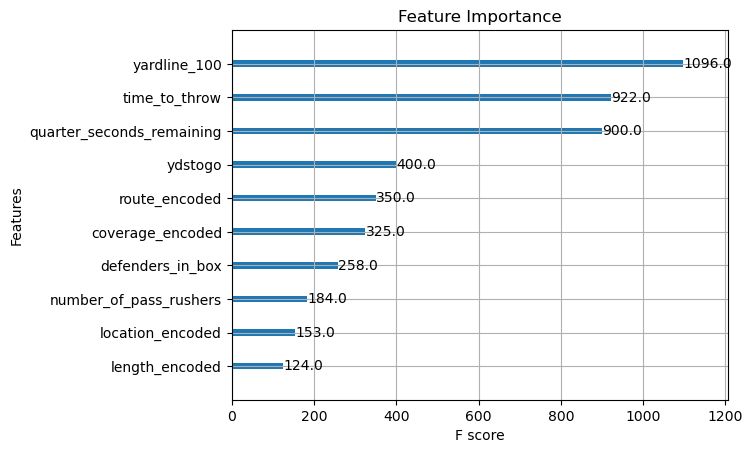

In [270]:
# Plot feature importances
xgb.plot_importance(model_epa, importance_type='weight', max_num_features=10)
plt.title('Feature Importance')
plt.show()

## Prediction Test

In [272]:
# Get coverages
coverages = data[x]['defense_coverage_type'].unique()
print(coverages)

KeyError: 7

In [276]:
# encode test features

predict_route = le_route.transform(['GO'])[0]
predict_pressure = le_pressure.transform([False])[0]
predict_length = le_length.transform(['short'])[0]
predict_location = le_location.transform(['left'])[0]


In [277]:
# Create dataframe to predict on

#X = df[['yardline_100', 'quarter_seconds_remaining', 'ydstogo', 'no_huddle', 'pass_length', 'pass_location', 'air_yards', 'out_of_bounds',
#        'defenders_in_box', 'number_of_pass_rushers', 'time_to_throw', 'was_pressure', 'route', 'defense_coverage_type']]

predict_data = pd.DataFrame()

for x in range(len(coverages)):
    new_row = {'yardline_100' : 25,
    'quarter_seconds_remaining': 120,
    'ydstogo': 75,
    'no_huddle': 0,
    'length_encoded': test_length,
    'location_encoded': test_location,
    'out_of_bounds': 1,
    'defenders_in_box': 7,
    'number_of_pass_rushers': 4,
    'time_to_throw': 2.1,
    'pressure_encoded': False,
    'route_encoded': test_route,
    'coverage_encoded': x
    }
    new_data = pd.DataFrame(new_row, index = [0])
    predict_data = pd.concat([predict_data, new_data])

    

In [278]:
# Create predictions
predicted_epa = model_epa.predict(predict_data)

# Add the predictions to the DataFrame
predict_data['coverage_type'] = coverages
predict_data['predicted_EPA'] = predicted_epa

# Print results
print(predict_data[['coverage_type', 'predicted_EPA']])

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:coverage_type: object

## Analysis

$MSE$ is quite high in this context as its value is suggesting the model is off by nearly a field goal. Perhaps outliers are severely affecting score. $R^2$ is also considerably low and is even negative.

In general, `PREVENT` seems to be the most effective route to minimize EPA, particularly when they're far from the end zone.

### Possible Improvements
- Find other regression models that would fit better
  - Our see how much outliers are affecting mean errors
- Add more features that better account for playstyle (e.g. QB cluster, team as a feature)
- Add features that account for quality of offense and defense
- Create a tree based on previous plays to get tendencies of offense throughout game
- Account for run
- Find way to generalize inputs (e.g. instead of specific yrdstogo, be able to input range of yrdstogo)
- Add features such as down and score_differential